In [1]:
import zipfile
import h5py
import os
import sys

import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchinfo

torch.cuda.is_available()

False

In [3]:
ziploc = '/home/btpq/bt308495/Thesis/molecular-vae/data/processed.zip'
contentsdest = '/localdisk/bt308495/molecular-vae/data/'

### Unzip file to 'contentdest'
# with zipfile.ZipFile(ziploc, 'r') as zpf:
#     zpf.extractall(contentsdest)

### Load data from unzipped file
with h5py.File(os.path.join(contentsdest, 'processed.h5'), 'r') as data:
    data_train =  data['data_train'][:]
    data_test =  data['data_test'][:]
    charset =  data['charset'][:]

In [4]:
data_train.shape, data_test.shape, charset.shape

((40000, 120, 33), (10000, 120, 33), (33,))

-------

In [5]:
test = data_train[0].copy()

In [6]:
def one_hot_to_smile(onehot_vector, character_set):
    ### Take a one-hot vector/tensor (MAX SMILE LENGTH, CHARSET LENGTH) and convert it to a smile string
    assert onehot_vector.shape[1] == character_set.size, 'Onehot length doesnt match character_set length'
    indicies = np.argmax(onehot_vector, axis=1)
    return b''.join(character_set[indicies])

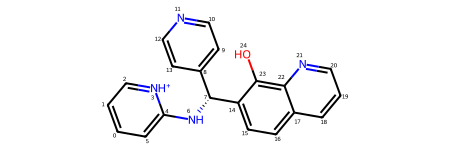

In [7]:
Chem.MolFromSmiles(one_hot_to_smile(data_train[30], charset))

In [8]:
smis = [one_hot_to_smile(d, charset) for d in data_train]

----

# VAE Model

In [57]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.CHARSET_LEN = 33
        self.INPUT_SIZE = 120
        self.LATENT_DIM = 292

        ### ENCODING
        # Convolutional Layers
        self.conv_1 = nn.Conv1d(self.INPUT_SIZE, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)

        # Fully Connected Layer
        self.linear_0 = nn.Linear(70, 435)

        # Mean and Variance Latent Layers
        self.mean_linear_1 = nn.Linear(435, self.LATENT_DIM)
        self.var_linear_2 = nn.Linear(435, self.LATENT_DIM)
        
        ### DECODING
        # Fully connected, GRU RNN, Fully connected layers
        # 3 sequential GRUs of hidden size 501. batch_first = True implies batch_dim first. 
        # Then, inputs into GRU are of shape [batch_size, seq_length (INPUT_SIZE, 120), Hin (LATENT_DIM, 292)]
        self.linear_3 = nn.Linear(self.LATENT_DIM, self.LATENT_DIM)
        self.stacked_gru = nn.GRU(self.LATENT_DIM, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, self.CHARSET_LEN)
        
        ### ACTIVATION and OUTPUT 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        # Convolutional
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))

        # Flatten the Convultional output [batch_size, 10, 70] to make an input [batch_size, 10*7] for a fully connected layer
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))

        # Mean and logvariance latent vectors [batch_size, latent_dim]
        m, v = self.mean_linear_1(x), self.var_linear_2(x) 
        return m, v

    def reparameterize(self, mu_z, logvar_z):
        ## Sample a latent vector 'z', given its mean and std vectors
        # z ~ N(mu, std), is non-differentiable. While z ~ mu + eps (dot) std, where eps ~ N(0, 1), is differentiable. Why?
        # Since mu and std are now deterministic model outputs that can be trained by backprop, while the 'randomness' implicitly enters via the standard normal error/epsilon term
        gamma = 1e-2 # not sure why this is here...?
        epsilon = gamma * torch.randn_like(logvar_z) # 0 mean, unit variance noise of shape z_logvar
        std = torch.exp(0.5 * logvar_z)
        z = mu_z + epsilon * std
        return z

    def decode(self, z):
        z = F.selu(self.linear_3(z))

        # Since the GRU, when unrolled in 'time', consists of 120 NNs each sequentially processing data... we have to send 120 copies through it.
        # By repeating the tensor z self.INPUT_SIZE times along the sequence length dimension, we are effectively creating a sequence of self.INPUT_SIZE time steps,
        # each with the same latent representation. This setup allows the GRU to process this "sequence" of repeated tensors, even though the actual sequence content
        # is the same at each time step. This kind of setup can be useful for example when:

        # 1. Information Propagation: 
        # Sometimes you want to ensure that a certain piece of information is propagated consistently through the entire sequence. By using repeated tensors, you can
        # ensure that the same information is available to the network at every time step, allowing the network to incorporate this information throughout the entire sequence.

        # 2. Fixed-Size Context: If you have a fixed-size context or control signal that should influence the processing of the entire sequence, you can repeat this
        # context along the sequence length dimension. This way, the network can take into account this context when making decisions at every time step.

        # Note on use of contiguous()
        # contiguous means 'sharing a common border; touching'
        # In the context of pytorch, contiguous means not only contiguous in memory (each element in a tensor is stored right next to the other, in a block),
        # but also in the same order in memory as the indices order. For example doing a transposition doesn't change the data in memory (data at (1, 4) doesnt swap
        # memory places when its transposed to (4, 1)), it simply changes the map from indices to memory pointers (what index corresponds to what data is swapped instead,
        # leaving memory untouched). If you then apply contiguous() it will change the data in memory so that the map from indices to memory location is the canonical one.
        # For certain pytorch operations, contiguously stored tensors are required! Else a runtime error is encountered (RuntimeError: input is not contiguous).

        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.INPUT_SIZE, 1) # Reshape z from [batch_size, latent_dim] to [batch_size, seq_len (120), latent_dim]
        output, hs = self.stacked_gru(z) # hs represents the hidden state of the last time step of the GRU

        # Output is flattened along 1st two dimensions [batch_size, seq_len, hout] -> [batch_size * seq_len, hout]
        # Softmax is then applied row-wise/sample-wise following a linear transform
        # before the vector is then unflatten back to the original [batch_size, seq_len, charset_len]

        # The purpose of this initial flattening is:
        # In the context of a sequence-to-sequence model, each time step's output from the RNN (or a similar sequential model) represents the model's understanding of the
        # data at that particular moment. When you collapse the dimensions and reshape the tensor to (batch_size * sequence_length, num_features), you effectively create 
        # a flat sequence where each element corresponds to a time step's output for a specific sample in the batch.
        # Then applying a linear transformation like self.linear_4 at this stage means that the same linear transformation is applied to each element in the flattened sequence
        # independently (as if the new batch size is of shape batch_size * seq_len)! This is independent in the sense that the transformation doesn't consider interactions
        # between different time steps or different samples within the batch. It's a per-element operation.

        # By applying a linear transformation independently to each element, the model has the flexibility to learn different weights for different features at different time steps.
        # These weights can capture complex relationships within each time step's output, such as identifying important features or capturing patterns specific to that moment.
        # We then reshape back to regain the sequence structure...
        out_independent = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_independent), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        zhat = self.decode(z)
        return zhat, mu_z, logvar_z

In [59]:
batch_size = 1
torchinfo.summary(VAE(), input_size=(batch_size, 120, 33))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 120, 33]              --
├─Conv1d: 1-1                            [1, 9, 25]                9,729
├─ReLU: 1-2                              [1, 9, 25]                --
├─Conv1d: 1-3                            [1, 9, 17]                738
├─ReLU: 1-4                              [1, 9, 17]                --
├─Conv1d: 1-5                            [1, 10, 7]                1,000
├─ReLU: 1-6                              [1, 10, 7]                --
├─Linear: 1-7                            [1, 435]                  30,885
├─Linear: 1-8                            [1, 292]                  127,312
├─Linear: 1-9                            [1, 292]                  127,312
├─Linear: 1-10                           [1, 292]                  85,556
├─GRU: 1-11                              [1, 120, 501]             4,212,909
├─Linear: 1-12                           [120, 33]   

In [ ]:
# test_z = torch.from_numpy(np.array((np.random.randn(292), np.random.randn(292)))).to(torch.float32)
# test_model = VAE()
# test_model.decode(test_z)

In [ ]:
# data_train_tensor[0].size(1)
# data_train_tensor[:2].shape, data_train_tensor[:2].view(data_train_tensor[:2].shape[0], -1).shape

In [21]:
data_train_tensor = torch.from_numpy(data_train)
data_train_tensor_loader = torch.utils.data.TensorDataset(torch.from_numpy(data_train))

In [63]:
# Calling the model() on data runs the forward pass through the network
VAE()(data_train_tensor[:2])

(tensor([[[0.0293, 0.0307, 0.0297,  ..., 0.0300, 0.0297, 0.0295],
          [0.0290, 0.0305, 0.0299,  ..., 0.0298, 0.0298, 0.0292],
          [0.0288, 0.0304, 0.0299,  ..., 0.0297, 0.0299, 0.0291],
          ...,
          [0.0284, 0.0301, 0.0298,  ..., 0.0295, 0.0300, 0.0289],
          [0.0284, 0.0301, 0.0298,  ..., 0.0295, 0.0300, 0.0289],
          [0.0284, 0.0301, 0.0298,  ..., 0.0295, 0.0300, 0.0289]],
 
         [[0.0293, 0.0307, 0.0297,  ..., 0.0300, 0.0297, 0.0295],
          [0.0290, 0.0305, 0.0299,  ..., 0.0298, 0.0299, 0.0292],
          [0.0288, 0.0304, 0.0299,  ..., 0.0297, 0.0299, 0.0291],
          ...,
          [0.0285, 0.0301, 0.0297,  ..., 0.0295, 0.0300, 0.0289],
          [0.0285, 0.0301, 0.0297,  ..., 0.0295, 0.0300, 0.0289],
          [0.0285, 0.0301, 0.0297,  ..., 0.0295, 0.0300, 0.0289]]],
        grad_fn=<ViewBackward0>),
 tensor([[-0.0247,  0.0105, -0.0620,  0.0238, -0.0278,  0.0079,  0.0418, -0.0597,
          -0.0270, -0.0361, -0.1300,  0.1268,  0.0400, -0

### Training

In [ ]:
def variational_loss(x_decoded_mean, x, z_mean, z_logvar):
    reconstruction_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return reconstruction_loss + kl_loss

In [64]:
data_train_tensor_loader = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train_tensor_loader, batch_size=250, shuffle=True)

In [66]:
torch.manual_seed(42)
epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VAE().to(device)
optimizer = optim.Adam(model.parameters())

In [ ]:
def train_step(MODEL):
    # Implement Tomorrow
    pass